In [1]:
import numpy as np
import gymnasium as gym
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
class Q_Learning:
    def __init__(self, env, alpha=0.1, gamma=1, epsilon=0.1, max_iter=45_000, bins=[50,50,50,50]):         
        self.env = env
        self.alpha = alpha
        self.gamma = gamma 
        self.epsilon = epsilon 
        self.action_index = env.action_space.n 
        self.max_iter = max_iter
        self.bins = bins
        self.l_bounds = env.observation_space.low
        self.h_bounds = env.observation_space.high
        self.all_rewards=[]         
        self.Q_matrix = np.random.uniform(low=0, high=1, size=(bins[0],bins[1],bins[2],bins[3],self.action_index))
            
    def discretizer(self):
        self.h_bounds[1] = 3
        self.h_bounds[3] = 10
        self.l_bounds[1] = -3
        self.l_bounds[3] = -10
        
        cart_P = np.linspace(self.l_bounds[0],self.h_bounds[0],self.bins[0])
        cart_V = np.linspace(self.l_bounds[1],self.h_bounds[1],self.bins[1])
        pole_Ang = np.linspace(self.l_bounds[2],self.h_bounds[2],self.bins[2])
        pole_Ang_V = np.linspace(self.l_bounds[3],self.h_bounds[3],self.bins[3])
        return (cart_P, cart_V, pole_Ang, pole_Ang_V)
        
    def status_index(self, status, cart_P, cart_V, pole_Ang, pole_Ang_V):
        index_P = np.digitize(status[0],cart_P)-1
        index_V = np.digitize(status[1],cart_V)-1
        index_Ang = np.digitize(status[2],pole_Ang)-1
        index_Ang_V = np.digitize(status[3],pole_Ang_V)-1
        return tuple([index_P, index_V, index_Ang, index_Ang_V])
        
    def action_select(self, status, cart_P, cart_V, pole_Ang, pole_Ang_V):
        if np.random.random() < self.epsilon:
            return np.random.choice(self.action_index)            
        else:
            return np.argmax(self.Q_matrix[self.status_index(status, cart_P, cart_V, pole_Ang, pole_Ang_V)])
    
    def training(self):
        cart_P, cart_V, pole_Ang, pole_Ang_V = self.discretizer()
        for iteration in tqdm(range(self.max_iter)):
            score=[]
            status = self.env.reset()[0]
            status = list(status)
            terminal_status = False
            while not terminal_status:
                status_index = self.status_index(status, cart_P, cart_V, pole_Ang, pole_Ang_V)
                action = self.action_select(status, cart_P, cart_V, pole_Ang, pole_Ang_V)
                status_next, reward, terminal_status = self.env.step(action)[:3]          
                score.append(reward)
                status_next = list(status_next)
                status_next_index = self.status_index(status_next, cart_P, cart_V, pole_Ang, pole_Ang_V)
                if not terminal_status:
                    Qmax_next = np.max(self.Q_matrix[status_next_index])                                               
                    self.Q_matrix[status_index + (action,)] = self.Q_matrix[status_index + (action,)] + self.alpha * \
                    reward + self.gamma * Qmax_next - self.Q_matrix[status_index + (action,)]
                else:
                    self.Q_matrix[status_index + (action,)] = -10
                status = status_next
            self.all_rewards.append(np.sum(score))
            
    def run(self):
        env_test = gym.make('CartPole-v1',render_mode='human')
        current_status = env_test.reset()[0]
        env_test.render()
        cart_P, cart_V, pole_Ang, pole_Ang_V = self.discretizer()
        terminated = False
        while not terminated:
            actionInstatus = np.argmax(self.Q_matrix[self.status_index(current_status, cart_P, cart_V, pole_Ang, pole_Ang_V)])
            current_status, reward, terminated, truncated, info = env_test.step(actionInstatus)
            if terminated:
                break
        return self.all_rewards, env_test

In [3]:
env = gym.make('CartPole-v1')
Ql = Q_Learning(env)
Ql.training()

100%|████████████████████████████████████████████████████████████████████████████| 45000/45000 [12:19<00:00, 60.89it/s]


In [4]:
all_rewards, env_test = Ql.run()
env_test.close()

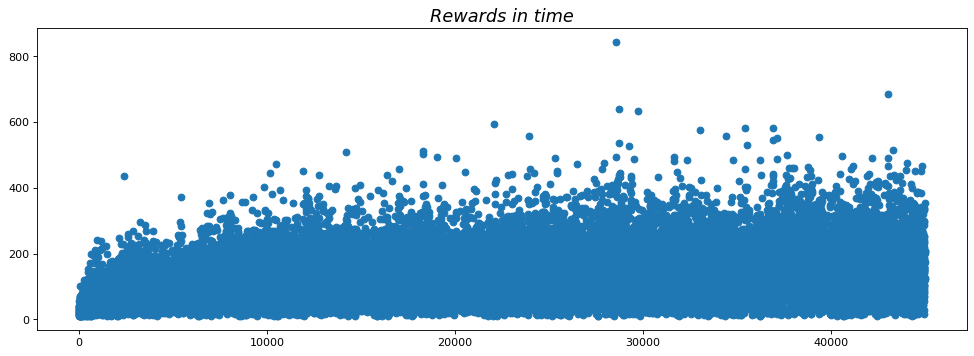

In [5]:
fig, ax = plt.subplots(figsize=(15, 5), dpi=80)

plt.title('Rewards in time', color='black', fontsize=16, fontstyle='italic')
ax.scatter(range(45000), all_rewards)
plt.show()

Медленно, но верно сумма наград увеличивается